# Import libraries

In [1]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

do confusion matrix for classification (calculate accuracy 

# Import cleaned dataset'

In [2]:
# Load data back for EDA
#rename unamed: 0 into id
news_data = pd.read_csv("cleaned_news\cleaned_news\cleaned_news.csv")

In [3]:
# View data
news_data.head()

,title,text,subject,date,label,label_meaning,processed_title,processed_text,title_polarity_score,text_polarity_score,...,title_pos_noun,title_pos_num,title_pos_pron,title_pos_verb,text_pos_adj,text_pos_adv,text_pos_noun,text_pos_num,text_pos_pron,text_pos_verb
0,Pennsylvania Church Demonstrates How To Deal ...,While many churches defend pastors who have ra...,News,"October 13, 2016",0,False,"['church', 'demonstrate', 'deal', 'pastor']","['many', 'church', 'defend', 'pastor', 'rap', ...",0.000,0.137722,...,4,0,0,0,31,11,106,3,0,20
1,Trump to keep Obama rule curbing corporate tax...,(This October 4 story fixes comment by Organi...,politicsNews,"October 4, 2017",1,True,"['trump', 'keep', 'rule', 'curb', 'corporate',...","['story', 'fix', 'comment', 'organization', 'i...",0.000,-0.083772,...,6,0,0,1,37,11,147,2,0,34
2,Trump says he's considering keeping parts of O...,(Reuters) - President-elect Donald Trump told ...,politicsNews,"November 11, 2016",1,True,"['trump', 'say', 'consider', 'keep', 'part']","['trump', 'tell', 'wall', 'street', 'journal',...",0.000,0.142177,...,2,0,0,2,32,7,94,2,0,33
3,CalPERS chief sees volatility until Trump impl...,SAN FRANCISCO (Reuters) - The California Publi...,politicsNews,"November 14, 2016",1,True,"['chief', 'see', 'volatility', 'trump', 'imple...","['san', 'public', 'employee', 'retirement', 's...",0.000,0.085190,...,4,0,0,1,32,7,58,1,0,15
4,House votes to protect 'dark money' political ...,WASHINGTON (Reuters) - The Republican-controll...,politicsNews,"June 14, 2016",1,True,"['house', 'vote', 'protect', 'dark', 'money', ...","['house', 'representative', 'vote', 'protect',...",-0.075,-0.002778,...,4,0,0,1,59,8,118,2,0,41


# Model training
Model 1: Decision Tree using K-Fold cross-validation

>  K-fold cross-validation is a specific type of cross-validation where the data is divided into k subsets of equal size. In k-fold cross-validation, the dataset is first divided into k equally sized subsets. Then, we repeat the train-test method k times so each time one of the k subsets is used as a test set and the rest k-1 subsets are used together as a training set.  The performance metrics are then averaged over the k iterations.

There is another method of cross-validation known as leave-one-out cross-validation, which only uses one data point in the subset as the test set and the other data points as the training set. However, it is more computationally expensive due to using more training samples in each iteration. Moreover, it is more suitable for smaller datasets. So we used K-Fold.

## Finding out what variables are the most impactful

In [4]:
def auto_kfold_decision_tree(variables):
    # Init list to record scores
    scores = {}
    
    # Response
    news_res = news_data['label_meaning']
    
    # Train for every variable
    for variable in variables:
        if variable.dtype == np.dtype('int64'):
            # Numeric variable
            news_cat = pd.DataFrame(variable)
            newsdata_ohe = pd.concat([news_cat, news_res], sort = False, axis = 1).reindex(index=news_cat.index)
        elif variable.dtype == np.dtype('object'):
            # Categorical variables
            # Import the encoder from sklearn
            ohe = OneHotEncoder()
            # OneHotEncoding of categorical predictors (not the response)
            news_cat = pd.DataFrame(variable)

            ohe.fit(news_cat)
            news_cat_ohe = pd.DataFrame(ohe.transform(news_cat).toarray(), columns=ohe.get_feature_names(news_cat.columns))
            
            newsdata_ohe = pd.concat([news_cat_ohe, news_res], sort = False, axis = 1).reindex(index=news_cat_ohe.index)

        # Extract Response and Predictors
        y = pd.DataFrame(newsdata_ohe['label_meaning'])
        X = pd.DataFrame(newsdata_ohe.drop('label_meaning', axis = 1))

        # Split the Dataset into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=2024)

        # Decision Tree using Train Data
        dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
        cv_results = cross_val_score(dectree, X_train, y_train['label_meaning'], cv=skf)

        # Record score
        scores[variable.name] = cv_results
        
    return scores

In [5]:
variables = [news_data['title_char_len'], 
             news_data['text_char_len'], 
             news_data['title_word_len'], 
             news_data['text_word_len'], 
             news_data['title_polarity_score'], 
             news_data['text_polarity_score'], 
             news_data['title_pos_adj'], 
             news_data['title_pos_adv'], 
             news_data['title_pos_noun'], 
             news_data['title_pos_num'], 
             news_data['title_pos_pron'], 
             news_data['title_pos_verb'], 
             news_data['text_pos_adj'], 
             news_data['text_pos_adv'], 
             news_data['text_pos_noun'], 
             news_data['text_pos_num'], 
             news_data['text_pos_pron'], 
             news_data['text_pos_verb']
            ]

scores = auto_kfold_decision_tree(variables)


for key, value in sorted(scores.items(), key=lambda x: x[1].mean(), reverse=True):
    print(f"Predictor: {key}, score: {value.mean():.2f}")

Predictor: title_word_len, score: 0.69
Predictor: title_char_len, score: 0.67
Predictor: text_pos_noun, score: 0.64
Predictor: text_char_len, score: 0.63
Predictor: title_pos_noun, score: 0.62
Predictor: text_word_len, score: 0.62
Predictor: title_polarity_score, score: 0.62
Predictor: text_polarity_score, score: 0.62
Predictor: text_pos_adj, score: 0.62
Predictor: text_pos_verb, score: 0.61
Predictor: text_pos_adv, score: 0.59
Predictor: title_pos_adj, score: 0.57
Predictor: title_pos_verb, score: 0.57
Predictor: text_pos_pron, score: 0.56
Predictor: title_pos_adv, score: 0.55
Predictor: text_pos_num, score: 0.54
Predictor: title_pos_num, score: 0.52
Predictor: title_pos_pron, score: 0.52


Top predictors are  title_word_len , title_char_len ,  text_pos_noun , title_polarity_score ,  text_char_len

## Training with top predictors

In [6]:
news_num = news_data[['title_word_len','title_char_len','text_pos_noun','text_polarity_score','text_char_len', 'title_pos_noun', 'text_polarity_score', 'text_pos_adj', 'text_word_len', 'text_pos_verb']]
news_res = news_data['label_meaning']
news_final = pd.concat([news_num,news_res],sort=False,axis=1).reindex(index=news_num.index)
# Check the final dataframe
news_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title_word_len       44898 non-null  int64  
 1   title_char_len       44898 non-null  int64  
 2   text_pos_noun        44898 non-null  int64  
 3   text_polarity_score  44898 non-null  float64
 4   text_char_len        44898 non-null  int64  
 5   title_pos_noun       44898 non-null  int64  
 6   text_polarity_score  44898 non-null  float64
 7   text_pos_adj         44898 non-null  int64  
 8   text_word_len        44898 non-null  int64  
 9   text_pos_verb        44898 non-null  int64  
 10  label_meaning        44898 non-null  bool   
dtypes: bool(1), float64(2), int64(8)
memory usage: 3.5 MB


## Create and fit model using decision tree

In [7]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_meaning'])
X = pd.DataFrame(news_final.drop('label_meaning', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2024)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment

X_train.head()

,title_word_len,title_char_len,text_pos_noun,text_polarity_score,text_char_len,title_pos_noun,text_polarity_score,text_pos_adj,text_word_len,text_pos_verb
21598,4,40,2,0.000000,32,2,0.000000,0,3,0
30107,6,56,78,-0.044318,1514,2,-0.044318,37,159,27
37591,6,58,19,0.008333,329,5,0.008333,8,37,3
39717,5,42,25,-0.068333,485,3,-0.068333,10,46,10
31982,9,83,82,-0.002140,1608,4,-0.002140,42,168,29


## Stratified k- fold for decision tree

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(dectree, X_train, y_train['label_meaning'], cv=skf)
cv_results, cv_results.mean()

(array([0.71237671, 0.7076042 , 0.71126312, 0.70214797, 0.71217184]),
 0.7091127686862574)

## Fitting data into decision tree

In [9]:
dectree.fit(X_train, y_train)                    # train the decision tree model

DecisionTreeClassifier(max_depth=4)

# Decision tree evaluation


## Plotting decision tree

[Text(0.5, 0.875, 'title_word_len <= 8.5\ngini = 0.499\nsamples = 31428\nvalue = [16410, 15018]\nclass = Fake'),
 Text(0.25, 0.625, 'text_char_len <= 131.5\ngini = 0.483\nsamples = 23866\nvalue = [9734, 14132]\nclass = Not Fake'),
 Text(0.125, 0.375, 'text_char_len <= 87.5\ngini = 0.068\nsamples = 707\nvalue = [682, 25]\nclass = Fake'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'title_word_len <= 6.5\ngini = 0.476\nsamples = 23159\nvalue = [9052.0, 14107.0]\nclass = Not Fake'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'title_word_len <= 9.5\ngini = 0.207\nsamples = 7562\nvalue = [6676, 886]\nclass = Fake'),
 Text(0.625, 0.375, 'text_pos_noun <= 167.5\ngini = 0.354\nsamples = 2938\nvalue = [2263, 675]\nclass = Fake'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'title_word_len <= 10.5\ngini = 0.087\nsamples = 4624\nvalue = 

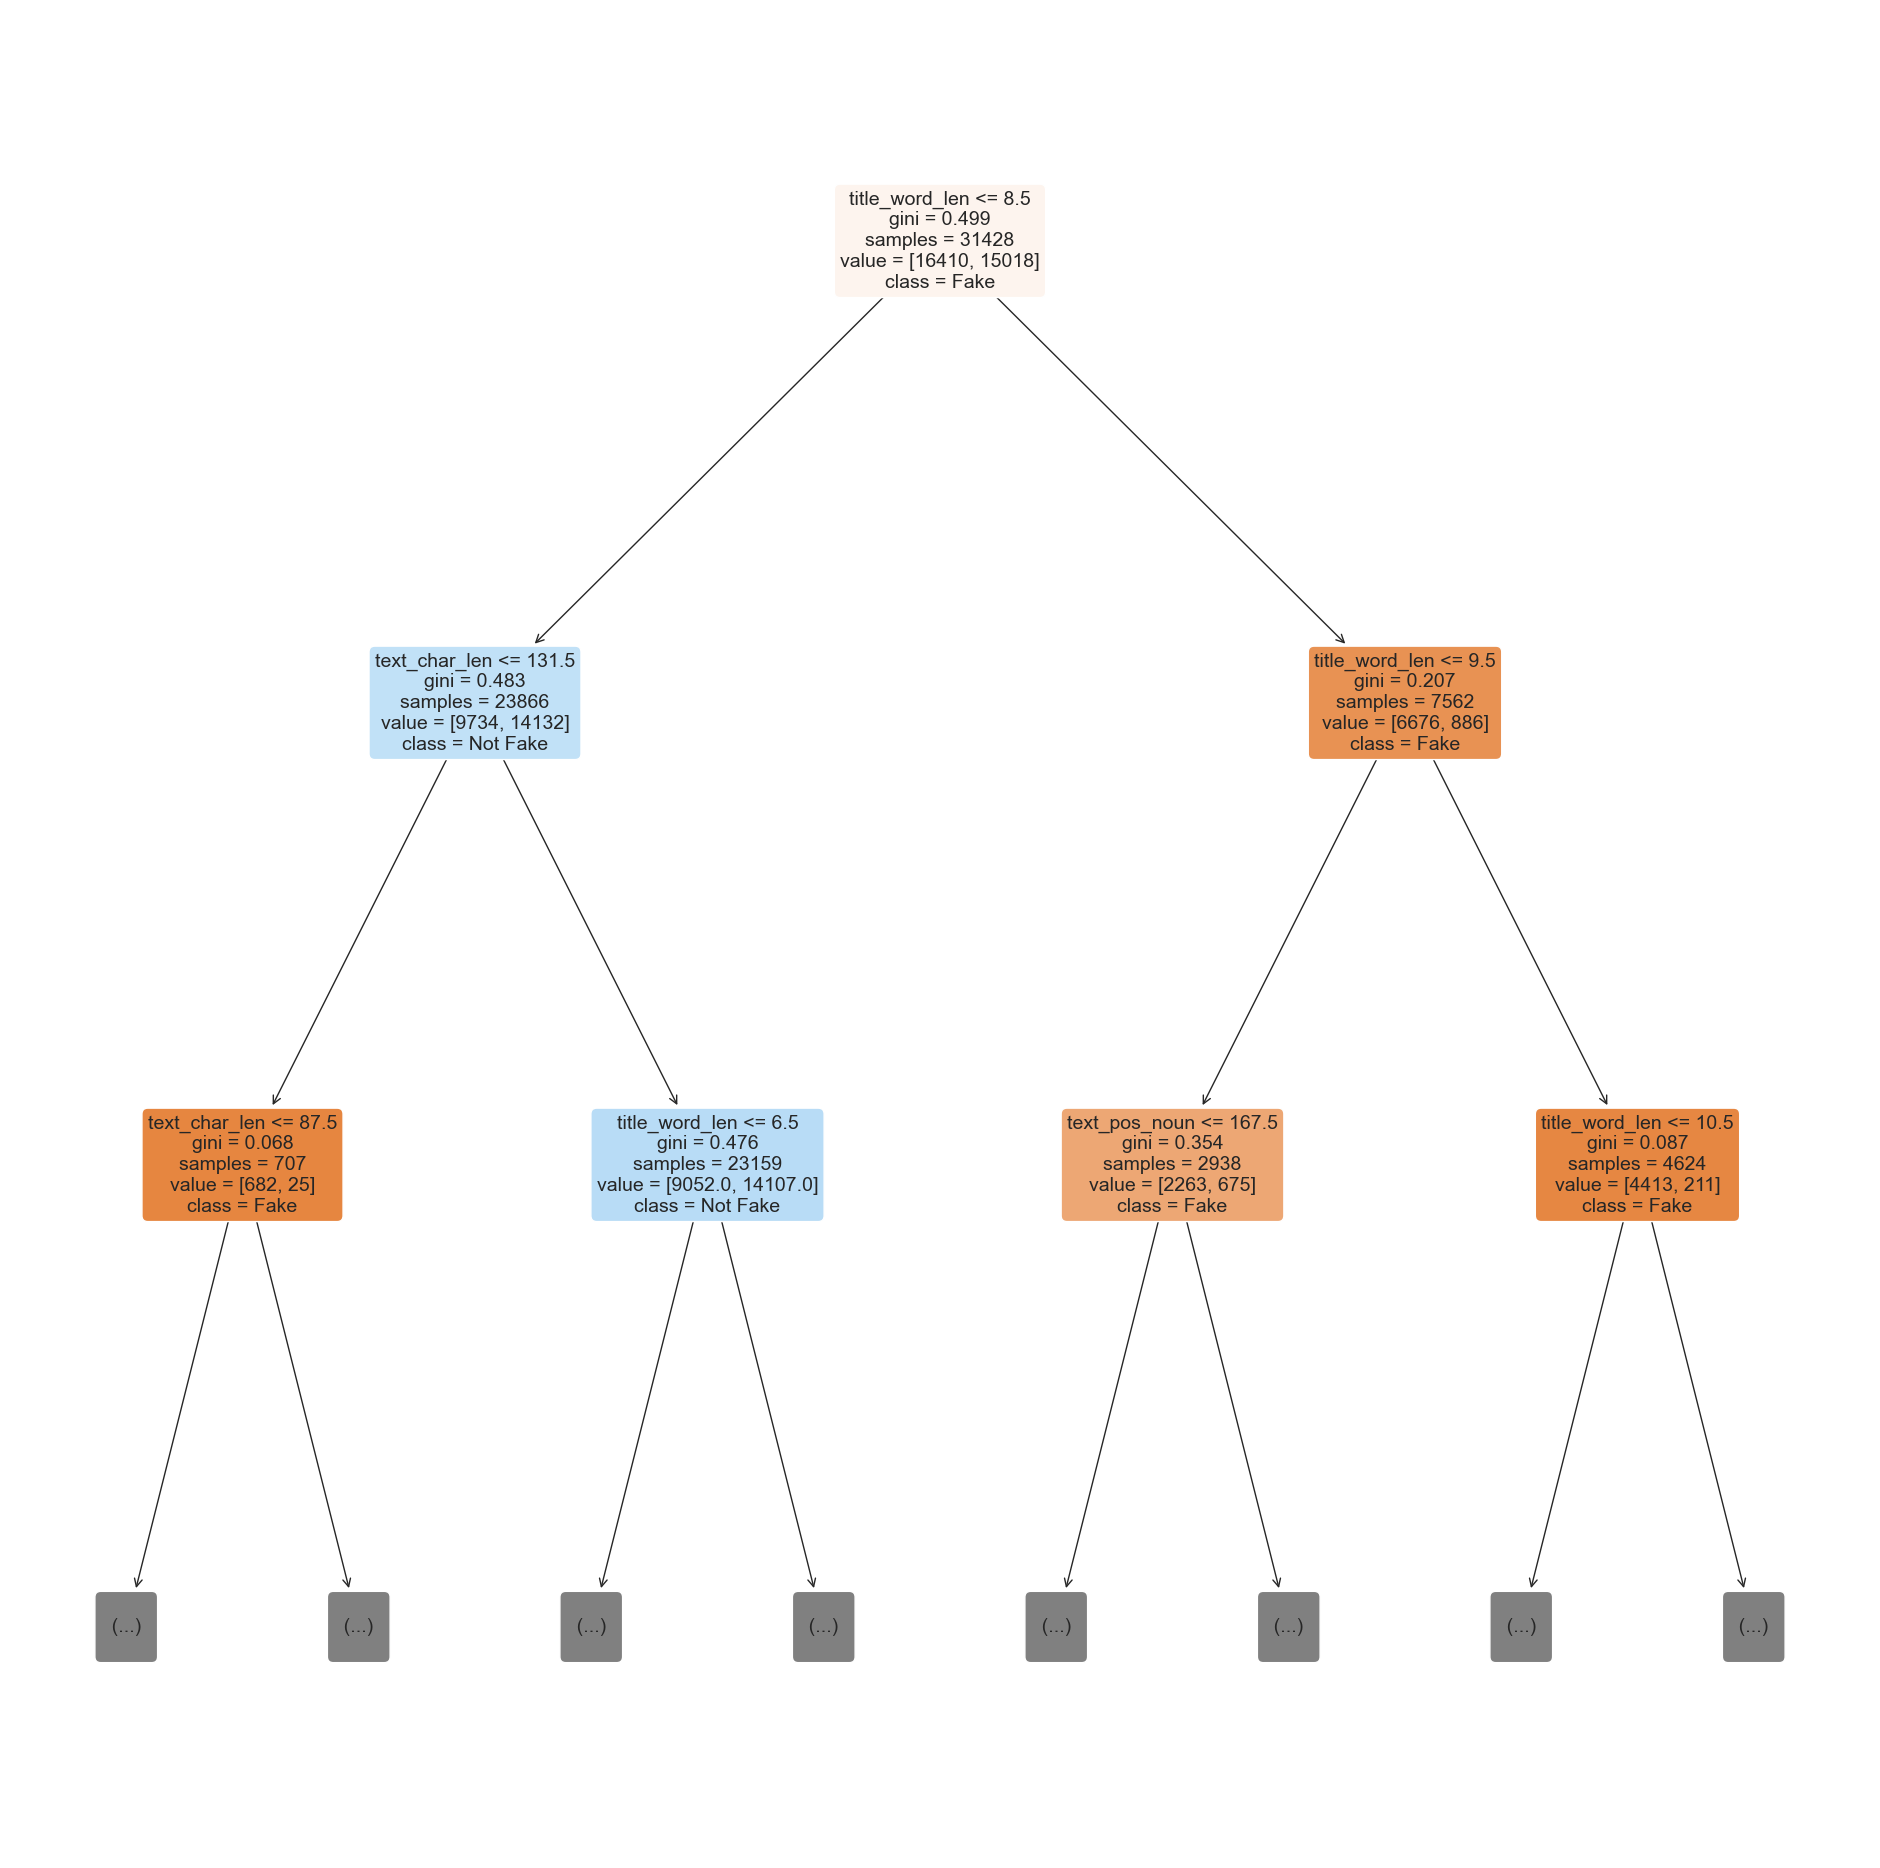

In [10]:
# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, max_depth=2,
          feature_names=X_train.columns, 
          class_names=["Fake","Not Fake"])

 The lower the Gini Index, the lower the likelihood of misclassification. 

## Confusion matrix

Train Data
Accuracy  :	 0.708412880234186

TPR Train :	 0.6857104807564256
TNR Train :	 0.7291895185862279

FPR Train :	 0.27081048141377206
FNR Train :	 0.3142895192435744


<Axes: >

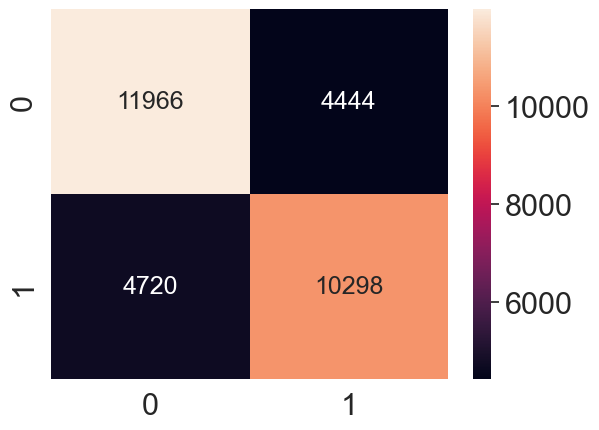

In [11]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7043801039346697

TPR Test :	 0.6779184247538678
TNR Test :	 0.7283269693112714

FPR Test :	 0.2716730306887286
FNR Test :	 0.32208157524613223


<Axes: >

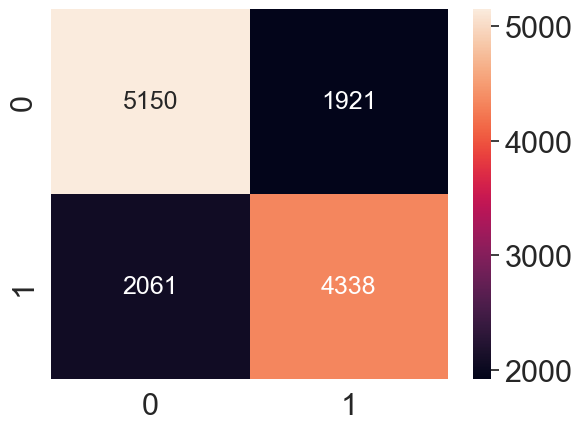

In [12]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Metrics

<Axes: >

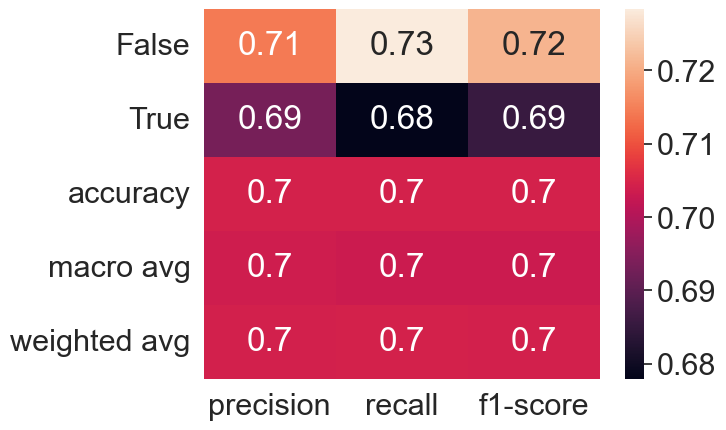

In [13]:
cr = classification_report(y_test, y_test_pred,output_dict=True)
#use seaborn to present the classification report
sb.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)

# Model 2: Random Forest Classifier

In [14]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_meaning'])
X = pd.DataFrame(news_final.drop('label_meaning', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2024)

In [15]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

## Stratified k-fold verification for random forest classifier 

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(rforest, X_train, y_train['label_meaning'], cv=skf)

In [17]:
cv_results, cv_results.mean()

(array([0.72748966, 0.72080815, 0.71603563, 0.72903739, 0.71964996]),
 0.7226041580448882)

## Fitting data into forest 

In [18]:
# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.label_meaning.ravel())

RandomForestClassifier(max_depth=4)

## Random Forest Model Evaluation 

### Confusion Matrix 

Train Data
Accuracy  :	 0.7233995163548428

TPR Train :	 0.8557064855506725
TNR Train :	 0.6023156611822059

FPR Train :	 0.397684338817794
FNR Train :	 0.14429351444932748


<Axes: >

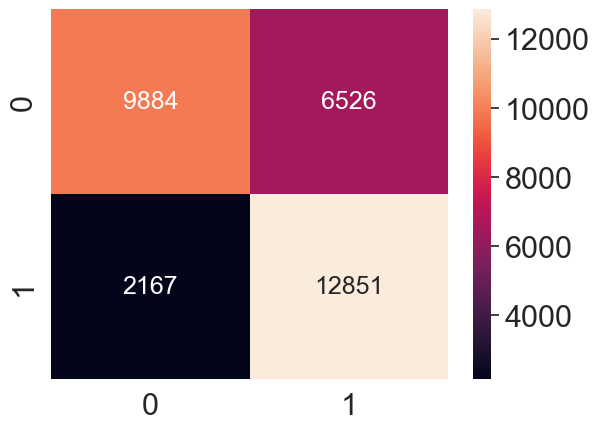

In [19]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7165553080920565

TPR Test :	 0.8470073448976403
TNR Test :	 0.5985009192476312

FPR Test :	 0.40149908075236884
FNR Test :	 0.15299265510235974


<Axes: >

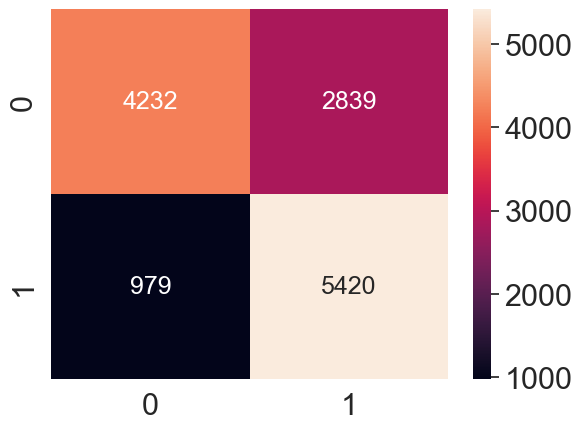

In [21]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})



<Axes: >

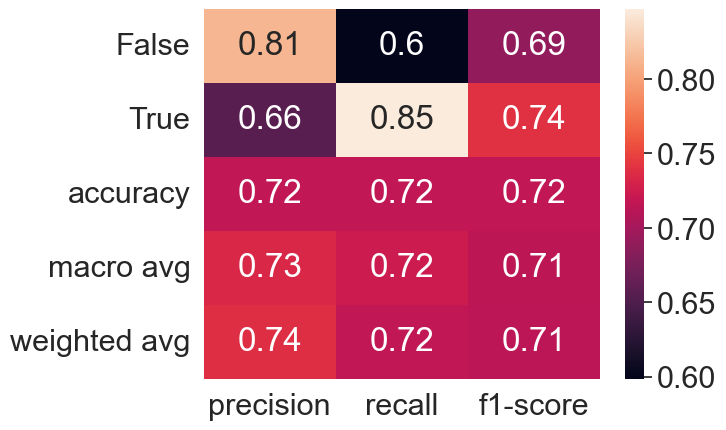

In [22]:
cr = classification_report(y_test, y_test_pred,output_dict=True)
#use seaborn to present the classification report
sb.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)

## Trying to improve accuracy by hyperparameter tuning using Cross-Validation (CV) 

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_meaning'])
X = pd.DataFrame(news_final.drop('label_meaning', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=2024)

In [ ]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.label_meaning.ravel())

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=800)
0.7534684316981759


In [25]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 800,  # n_estimators denote number of trees
                                 max_depth = 10)       # set the maximum depth of each tree

In [26]:
rforest.fit(X_train, y_train.label_meaning.ravel())

RandomForestClassifier(max_depth=10, n_estimators=800)

Test Data
Accuracy  :	 0.7591685226429101

TPR Test :	 0.8160237388724035
TNR Test :	 0.7076552992783359

FPR Test :	 0.2923447007216641
FNR Test :	 0.18397626112759644


<Axes: >

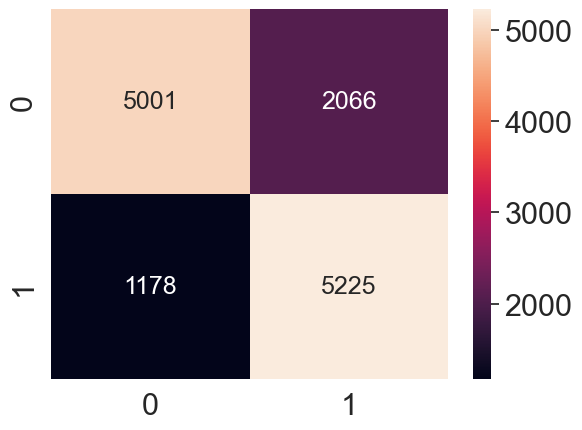

In [27]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})



<Axes: >

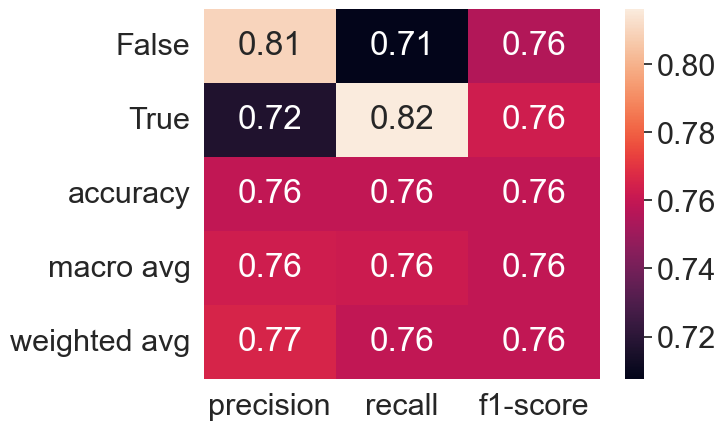

In [28]:
cr = classification_report(y_test, y_test_pred,output_dict=True)
#use seaborn to present the classification report
sb.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)

#### Interesting finding: Our first model, decision tree does not use internal resampling, it suffices to conduct train-test splitting to plot the tree. But for our second model, random forest, involved internal resampling, specifically bootstrapping.  Bootstrapping is random sampling with replacement, such that each decision tree in the forest is trained on a different bootstrapped dataset. Thus this injects randomness and helps prevent overfitting within the random forest itself. We did not explicitly implement bootstrapping in our random forest here, since the default RandomForestClassifier already leverages bootstrapping for training the individual trees in the forest.  

#### On another note, resampling of our train-test sets is not required, since our training and testing sets have almost equal balance of real and false news. This implies a balanced dataset with minimal class imbalance, so we do not have to resample for both models.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f23536d-6e62-418a-b94b-ca9356b2599b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>